# Prologue

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config

### Config

In [2]:
pd.set_option('display.max_columns', 100)
set_config(transform_output='pandas')

## definitions

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## data

In [4]:
path = 'data/cirrhosis.csv'
df = pd.read_csv(path)

original_df = df.copy()
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

* What is the target? (You are required to complete a classification task for this project)
  * Status is the target. A patient can be Censored (C), meaning they were alive at the end of the observation period, Censored due to liver transplant (CL), or Died (D)

* What does one row represent? (A person? A business? An event? A product?)
  * A person

* How many features does the data have?
  * 19 features, plus the N_Days column, which the source lists as "other"

* How many rows are in the dataset?
  * 418

* What opportunities exist for dimensionality reduction or feature selection with this dataset?
  *

* What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
  *

# Model 1

In [6]:
df = original_df.copy()
df.head()


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [7]:
df = df.loc[df['Status'] != 'CL']
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0


In [8]:
df['Status'].value_counts()

C    232
D    161
Name: Status, dtype: int64

In [9]:
df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             100
Age                0
Sex                0
Ascites          100
Hepatomegaly     100
Spiders          100
Edema              0
Bilirubin          0
Cholesterol      127
Albumin            0
Copper           102
Alk_Phos         100
SGOT             100
Tryglicerides    129
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [10]:
df = df.drop(columns=['ID'])
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0


## train/test split

In [11]:
X = df.drop(columns='Status')
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
349,662,NaN,17532,F,NaN,NaN,NaN,N,2.1,NaN,4.10,NaN,NaN,NaN,NaN,200.0,9.0,3.0
189,2504,D-penicillamine,19916,F,N,N,Y,N,2.3,NaN,3.93,24.0,1828.0,133.30,NaN,327.0,10.2,2.0
178,2573,Placebo,16050,F,N,Y,N,N,1.8,396.0,3.83,39.0,2148.0,102.30,133.0,278.0,9.9,4.0
64,3992,D-penicillamine,14684,F,N,N,N,N,1.2,256.0,3.60,74.0,724.0,141.05,108.0,430.0,10.0,1.0
363,359,NaN,21550,F,NaN,NaN,NaN,N,2.7,NaN,3.35,NaN,NaN,NaN,NaN,142.0,11.5,4.0


## Pipelines

In [12]:
mean_imputer = SimpleImputer(strategy='mean')
ohe = OneHotEncoder(drop='first', sparse_output=False)
scale = StandardScaler()

ohe_cols = X_train.select_dtypes('object').columns.tolist()
num_cols = X_train.select_dtypes('number').columns.tolist()

ohe_cols, num_cols

(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'],
 ['N_Days',
  'Age',
  'Bilirubin',
  'Cholesterol',
  'Albumin',
  'Copper',
  'Alk_Phos',
  'SGOT',
  'Tryglicerides',
  'Platelets',
  'Prothrombin',
  'Stage'])

In [13]:
constant_imputer = SimpleImputer(strategy='constant', fill_value='NA')

In [14]:
ohe_pipe = make_pipeline(constant_imputer, ohe)
num_pipe = make_pipeline(mean_imputer, scale)

ohe_tuple = ('ohe', ohe_pipe, ohe_cols)
num_tuple = ('num', num_pipe, num_cols)

In [15]:
transformer = ColumnTransformer([ohe_tuple, num_tuple], verbose_feature_names_out=False)
transformer

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [16]:
transformer.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                  'Spiders', 'Edema']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['N_Days', 'Age', 'Bilirubin', 'Cholesterol',
                                  'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                  'Tryglicerides', 'Platelets', 'Prothrombin',
                                  'Stage'])],
                  verbose_feature_names_out=False)

In [17]:
X_train_trans = transformer.transform(X_train)
X_test_trans = transformer.transform(X_test)

## Fit and Model

In [18]:
knn = KNeighborsClassifier()

In [19]:
knn.fit(X_train_trans, y_train)

KNeighborsClassifier()

## Evaluate

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.82      0.94      0.88       193
           D       0.88      0.68      0.77       121

    accuracy                           0.84       314
   macro avg       0.85      0.81      0.82       314
weighted avg       0.85      0.84      0.84       314



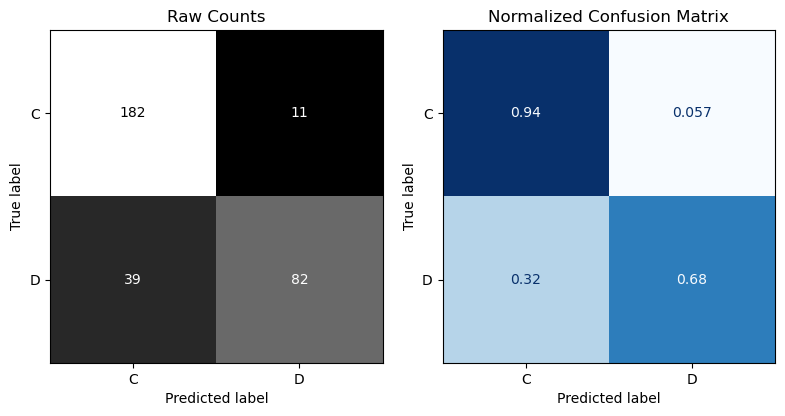


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.74      0.82      0.78        39
           D       0.81      0.72      0.76        40

    accuracy                           0.77        79
   macro avg       0.77      0.77      0.77        79
weighted avg       0.78      0.77      0.77        79



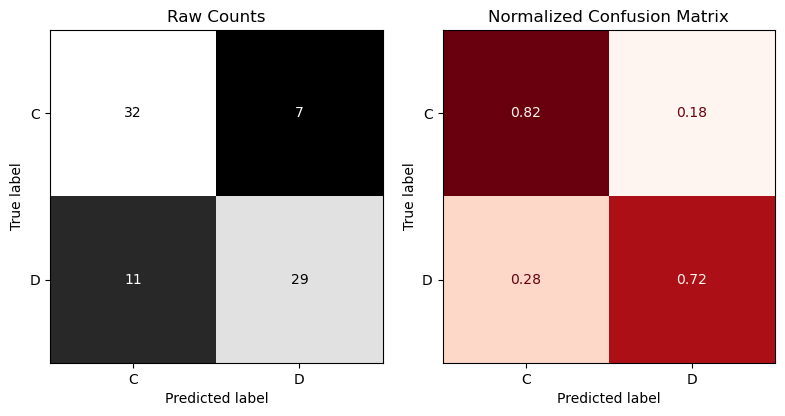

In [20]:
evaluate_classification(knn, X_train_trans, y_train,X_test_trans, y_test, figsize=(8,4), normalize='true', output_dict = False);

# Insights

## Extract and visualize the top 10 features using permutation importance

In [21]:
type(X_train_trans)

pandas.core.frame.DataFrame

In [22]:
from sklearn.inspection import permutation_importance
from sklearn import set_config
 

# Perform permutation importance

result = permutation_importance(knn, X_train_trans, y_train, n_repeats=10, random_state=42)
# ValueError: Found input variables with inconsistent numbers of samples: [314, 249]


# Get the top 10 features
top_features_idx = result.importances_mean.argsort()[-10:]

# # Get the names of the top 10 features
top_features_names = X_train_trans.columns[top_features_idx]




In [23]:
imp_means = pd.Series(result.importances_mean, index=X_train_trans.columns)
imp_means

Drug_NA           -0.000637
Drug_Placebo       0.003185
Sex_M              0.007962
Ascites_NA        -0.000637
Ascites_Y          0.002866
Hepatomegaly_NA   -0.000637
Hepatomegaly_Y     0.009554
Spiders_NA        -0.000637
Spiders_Y         -0.007962
Edema_S           -0.000955
Edema_Y            0.003185
N_Days             0.032803
Age                0.027707
Bilirubin          0.033439
Cholesterol        0.022611
Albumin            0.015287
Copper             0.014650
Alk_Phos           0.021019
SGOT               0.009873
Tryglicerides     -0.000637
Platelets          0.009236
Prothrombin        0.031210
Stage              0.015287
dtype: float64

<Axes: >

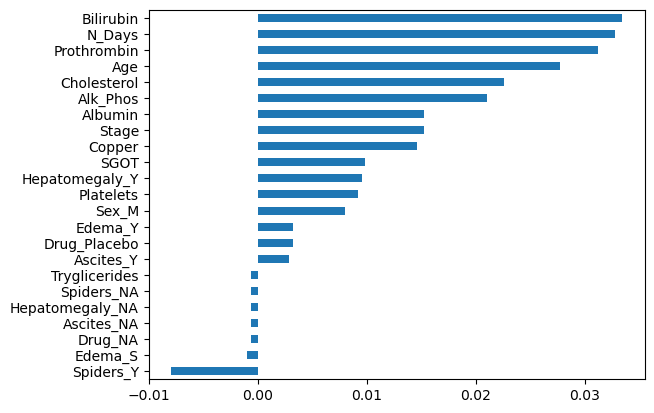

In [24]:
imp_means = imp_means.sort_values()
imp_means.plot(kind='barh')

## Extract and visualize

In [25]:
top_ten = imp_means[-10:]
top_ten

SGOT           0.009873
Copper         0.014650
Stage          0.015287
Albumin        0.015287
Alk_Phos       0.021019
Cholesterol    0.022611
Age            0.027707
Prothrombin    0.031210
N_Days         0.032803
Bilirubin      0.033439
dtype: float64

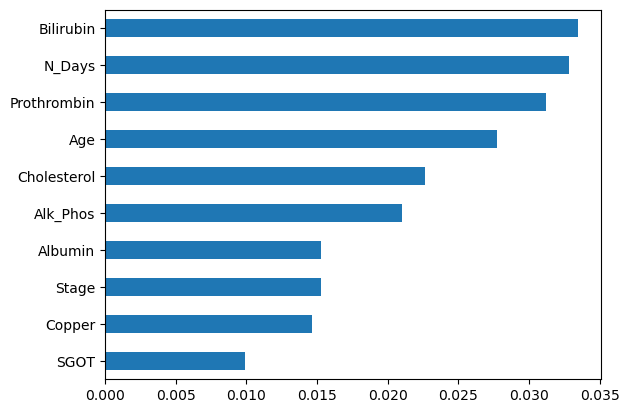

In [26]:
top_ten.plot(kind='barh')

plt.savefig('top_ten_features.png')

In [27]:
top_ten.to_csv('top_ten_features', index=False)

In [28]:
plot_df = df[['N_Days', 'Age', 'Status']]
plot_df.head()

,N_Days,Age,Status
0,400,21464,D
1,4500,20617,C
2,1012,25594,D
3,1925,19994,D
5,2503,24201,D


In [29]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 417
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N_Days  393 non-null    int64 
 1   Age     393 non-null    int64 
 2   Status  393 non-null    object
dtypes: int64(2), object(1)
memory usage: 12.3+ KB


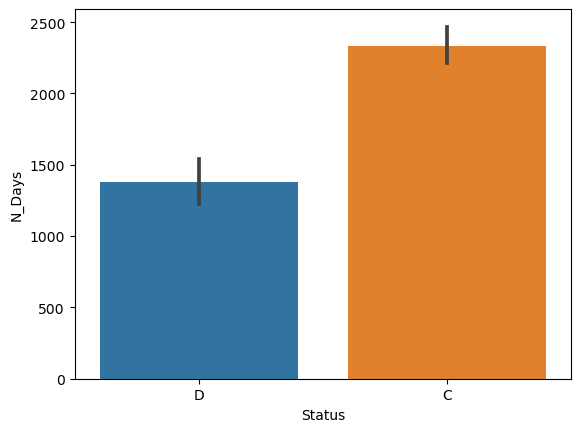

In [30]:
sns.barplot(x='Status', y='N_Days', data=plot_df);

* N_Days is the number of days the patient was in the trial, from registration to death, transplant, or study analysis in July 1986
  * The plot above shows that patients who were in the study longer were more likely to survive. This may imply that a longer course of treatment with the study drug is effective at improving patients' prognosises, but could be confounded by the fact that all patients who died during the trial did so before the analysis period.

<Axes: xlabel='Status', ylabel='Age'>

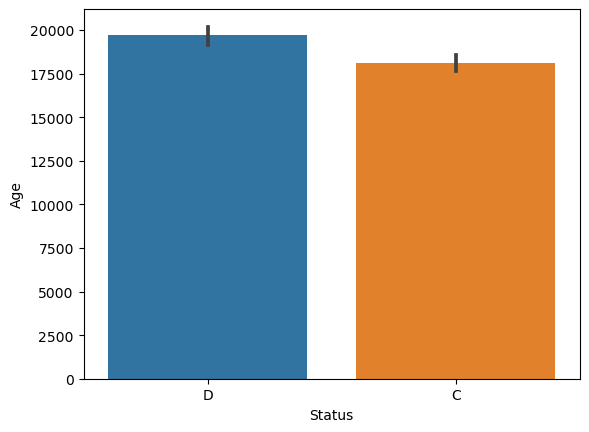

In [31]:
sns.barplot(x='Status', y='Age', data=plot_df)

In [32]:
df.Age.describe()

count      393.000000
mean     18743.582697
std       3797.459981
min       9598.000000
25%      16050.000000
50%      18964.000000
75%      21483.000000
max      28650.000000
Name: Age, dtype: float64

Convert Age from days to years

In [33]:
# define "year"
year_dict = {
  "julian": 365.25,
  "gregorian": 365.2425,
  "sidereal": 365.25636,
  "tropical": 365.24219,
  "anomalistic": 365.25964,
  "eclipse": 346.62008,
  "synodic": 29.53059 * 12,
  "draconic": 27.21222 * 12
}

We'll use the gregorian year, since it's the most commonly used. A trade-off is that the length of a gregorian year changes over time. We'll use the average year length in days.

In [37]:
min_age = df['Age'].min() / year_dict['gregorian']
max_age = df['Age'].max() / year_dict['gregorian']
mean_age = df['Age'].mean() / year_dict['gregorian']
median_age = df['Age'].median() / year_dict['gregorian']

# show these in a dataframe
age_df = pd.DataFrame({
  "min_age": min_age,
  "max_age": max_age,
  "mean_age": mean_age,
  "median_age": median_age
}, index=["age"])

age_df.head()


,min_age,max_age,mean_age,median_age
age,26.278431,78.441036,51.318186,51.921668


* With a range of 26-78 years of age, it's not surprising that older patients were more likely to die during the study period, since younger people are more likely to receive a transplant; while older people have a higher rate of death from all causes.